En este proyecto, trataremos de relizar un análisis de como se van a comportar los arribos de los paquetes para los países Peru y Colombia, segun diferentes caracterisitcas. En este caso se tomara en cuenta quien liberara la guia (Customs clearance officer), el cliente que envia el paquete (Client) y el servicio del paquete (Service).

Para empezar, enlazaremos la base de datos a la notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ruta_archivo = 'https://docs.google.com/spreadsheets/d/1dzpaJqCpXMF8tOx6LvmflD4pvy4zsUzay6gpThLz8zU/edit?gid=1778327264#gid=1778327264'

In [3]:
import pandas as pd
df = pd.read_csv(ruta_archivo)

El código, no esta tirando un error "ParserError: Error tokenizing data, que indica que pd.read_csv está encontrando un problema mientras analiza el archivo CSV desde la URL de Google Sheets proporcionada. Para resolver este problema, se usará la biblioteca gspread junto con la API de Google Drive para leer correctamente la hoja de Google:

In [4]:
!pip install gspread
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 70.3 MB/s eta 0:00:00
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.160.0
    Uninstalling google-api-python-client-2.160.0:
      Successfully uninstalled google-api-python-client-2.160.0


In [5]:
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1dzpaJqCpXMF8tOx6LvmflD4pvy4zsUzay6gpThLz8zU/edit?gid=1778327264#gid=1778327264'
sheet = gc.open_by_url(spreadsheet_url).sheet1

In [6]:
df = pd.DataFrame(sheet.get_all_records())

Una vez conectada la notebook, pasaremos a utilizar el feature selction, para analizar la predicción

In [7]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Como ya cargamos el dataset anteriormente, pasaremos a codificar las variables categóricas:

In [8]:
categorical_features = ['Airline', 'Origin_Country', 'Origin_Airport', 'Destination_Country',
                        'Destination_Airport', 'Customs clearance officer', 'Client', 'Service']
for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])

Definir las variables predictoras (X) y la variable objetivo (y):

In [9]:
X = df[['AWB', 'Airline', 'Origin_Country', 'Origin_Airport', 'Destination_Country',
        'Destination_Airport', 'Bags', 'KG_Bags', 'Departure', 'ETA_Forecast',
        'ETA_Ajustado', 'Arrival_AR_1_002', 'Month', 'Customs clearance officer', 'Client', 'Service']]
y = df['Packages']

Dividiremos el dataset en conjuntos de entrenamiento y prueba:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Elegir un método de Feature Selection, como tenemos una variable objetivo numérica, eligiremos f_classif:


In [11]:
metodo_de_seleccion = f_classif

Antes de podes seguir, vamos a verificar que todas las columnas sean numericas:

In [12]:
import pandas as pd

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        print(f"La columna '{column}' es numérica.")
    elif pd.api.types.is_categorical_dtype(df[column]):
        print(f"La columna '{column}' es categórica.")
    else:
        print(f"La columna '{column}' es de tipo object (puede ser texto o mixto).")

La columna 'AWB' es de tipo object (puede ser texto o mixto).
La columna 'Airline' es numérica.
La columna 'Origin_Country' es numérica.
La columna 'Origin_Airport' es numérica.
La columna 'Destination_Country' es numérica.
La columna 'Destination_Airport' es numérica.
La columna 'Bags' es numérica.
La columna 'Packages' es numérica.
La columna 'KG_Bags' es numérica.
La columna 'Departure' es de tipo object (puede ser texto o mixto).
La columna 'ETA_Forecast' es de tipo object (puede ser texto o mixto).
La columna 'ETA_Ajustado' es de tipo object (puede ser texto o mixto).
La columna 'Arrival_AR_1_002' es de tipo object (puede ser texto o mixto).
La columna 'Month' es numérica.
La columna 'Customs clearance officer' es numérica.
La columna 'Client' es numérica.
La columna 'Service' es numérica.


<ipython-input-12-442d877bde8f>:6: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column]):


Podemos ver que varias son object, por la que las pasaremos a numéricas:

In [13]:
object_cols = df.select_dtypes(include=['object']).columns
print(object_cols)

Index(['AWB', 'Departure', 'ETA_Forecast', 'ETA_Ajustado', 'Arrival_AR_1_002'], dtype='object')


In [14]:
for col in object_cols:
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        print(f"La columna '{col}' no se puede convertir a numérica. Puede contener valores no numéricos.")

La columna 'AWB' no se puede convertir a numérica. Puede contener valores no numéricos.
La columna 'Departure' no se puede convertir a numérica. Puede contener valores no numéricos.
La columna 'ETA_Forecast' no se puede convertir a numérica. Puede contener valores no numéricos.
La columna 'ETA_Ajustado' no se puede convertir a numérica. Puede contener valores no numéricos.
La columna 'Arrival_AR_1_002' no se puede convertir a numérica. Puede contener valores no numéricos.


Como esas columnas no se pueden convertir en numéricas, las sacaremos del data base, ya que no nos sirven para poder realizar el Feature Selection:

In [15]:
X = df[['Airline', 'Origin_Country', 'Origin_Airport', 'Destination_Country',
        'Destination_Airport', 'Bags', 'KG_Bags', 'Month', 'Customs clearance officer', 'Client', 'Service']]
y = df['Packages']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
metodo_de_seleccion = f_classif

In [18]:
selector = SelectKBest(score_func=metodo_de_seleccion, k=10) # Seleccionar las 10 mejores características
X_new = selector.fit_transform(X_train, y_train)

In [19]:
selected_features = X_train.columns[selector.get_support()]
print("Características seleccionadas:", selected_features)

Características seleccionadas: Index(['Airline', 'Origin_Airport', 'Destination_Country',
       'Destination_Airport', 'Bags', 'KG_Bags', 'Month',
       'Customs clearance officer', 'Client', 'Service'],
      dtype='object')


Con las características seleccionadas, pasaremos a realizar un análisis de regresión lineal, nuestro database es puramente numérico, por lo que es la mejor opción. Vamos a predecir la cantidad de paquetes que arribaran en el 2025, por país, teniendo en cuenta el cliente que envia la carga, el proveedor que lo liberara y el servicio que se brinda a ese paquete:

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [21]:
X = df[['Destination_Country', 'Month', 'Customs clearance officer', 'Client', 'Service']]
y = df['Packages']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Como no se puede convertir el destino, pasaremos a realizar un par de cambios y codificaremos el país de destino:

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

le_country = LabelEncoder()

df['Destination_Country_Encoded'] = le_country.fit_transform(df['Destination_Country'])

X = df[['Destination_Country_Encoded', 'Month', 'Customs clearance officer', 'Client', 'Service']]
y = df['Packages']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Como ahora tenemos error con los proveedores, procederemos a codificar dicha columna:

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

le_officer = LabelEncoder()

df['Customs clearance officer_Encoded'] = le_officer.fit_transform(df['Customs clearance officer'])

X = df[['Destination_Country_Encoded', 'Month', 'Customs clearance officer_Encoded', 'Client', 'Service']]
y = df['Packages']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Volvemos a repetir la codificación con las columnas cliente y servicio:

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

le_country = LabelEncoder()
le_officer = LabelEncoder()
le_client = LabelEncoder()  # Encoder for Client
le_service = LabelEncoder() # Encoder for Service


df['Destination_Country_Encoded'] = le_country.fit_transform(df['Destination_Country'])
df['Customs clearance officer_Encoded'] = le_officer.fit_transform(df['Customs clearance officer'])
df['Client_Encoded'] = le_client.fit_transform(df['Client'])  # Encode Client column
df['Service_Encoded'] = le_service.fit_transform(df['Service']) # Encode Service column


X = df[['Destination_Country_Encoded', 'Month', 'Customs clearance officer_Encoded', 'Client_Encoded', 'Service_Encoded']]
y = df['Packages']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Como la regreción no nos trajo nada, veremos de cambiar un poco el enfoque, pidiendo que utilice la moda de cada columna:

In [27]:
import pandas as pd

paises = df['Destination_Country_Encoded'].unique()

data_prediccion = pd.DataFrame()

for pais in paises:
    for mes in range(1, 13):
        nueva_fila = pd.DataFrame({
            'Destination_Country_Encoded': [pais],
            'Month': [mes],
            'Customs clearance officer_Encoded': [df['Customs clearance officer_Encoded'].mode()[0]], # Usa la moda
            'Client_Encoded': [df['Client_Encoded'].mode()[0]],  # Usa la moda
            'Service_Encoded': [df['Service_Encoded'].mode()[0]]  # Usa la moda
        })
        data_prediccion = pd.concat([data_prediccion, nueva_fila], ignore_index=True)

Ahora podemos realizar la predicción:

In [28]:
data_prediccion['Packages_Prediccion'] = model.predict(data_prediccion)

Y ahora pasaremos a realizar una regresión lineal:

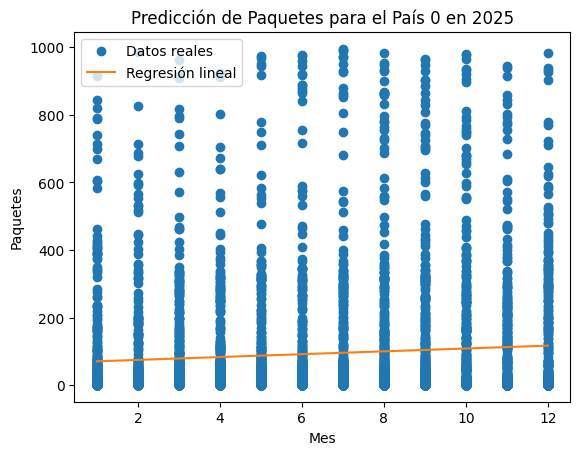

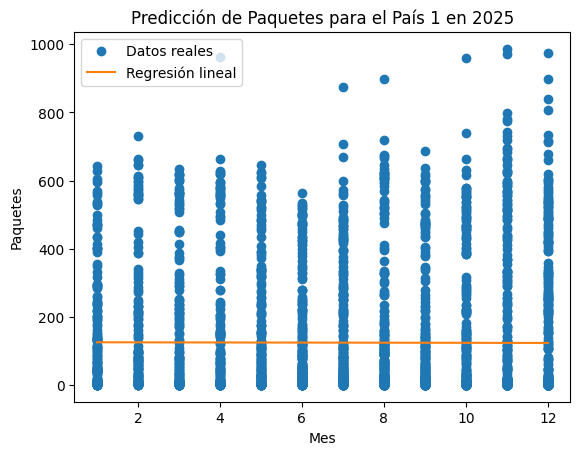

In [29]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

grouped = df.groupby('Destination_Country_Encoded')

for name, group in grouped:

    X = group[['Month']]
    y = group['Packages']

    model = LinearRegression()
    model.fit(X, y)

    meses_2025 = pd.DataFrame({'Month': range(1, 13)})

    predicciones = model.predict(meses_2025)

    plt.plot(group['Month'], group['Packages'], 'o', label='Datos reales')  # Puntos de datos reales
    plt.plot(meses_2025['Month'], predicciones, '-', label='Regresión lineal')  # Línea de regresión
    plt.title(f'Predicción de Paquetes para el País {name} en 2025')
    plt.xlabel('Mes')
    plt.ylabel('Paquetes')
    plt.legend()
    plt.show()

para poder sacar conclusiones, primero tengo que saber cual es cada pais:

In [30]:
for i, pais in enumerate(le_country.classes_):
    print(f"País {i}: {pais}")

País 0: 0
País 1: 1


Podemos ver que el país 0 (Colombia), sigue una regreción lineal positiva, mientras que el pais 1 (Peru) es nula. Podemos comaprar esto con los daatos reales del 2024:

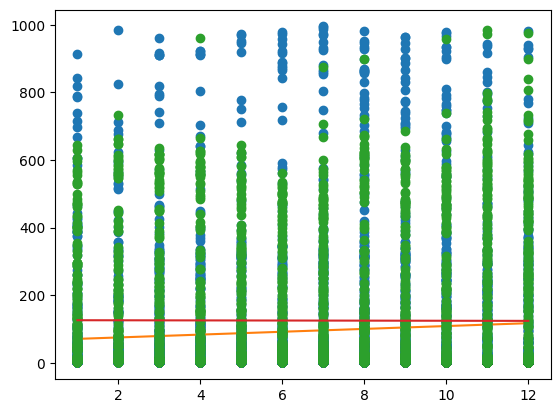

In [31]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

grouped = df.groupby('Destination_Country_Encoded')

for name, group in grouped:
    X_original = group[['Month']]
    y_original = group['Packages']

    model_original = LinearRegression()
    model_original.fit(X_original, y_original)

    plt.plot(X_original, y_original, 'o', label='Datos reales 2024')
    plt.plot(X_original, model_original.predict(X_original), '-', label='Regresión lineal 2024')

Como podemos observar, hay un país que se mantiene constante, mientras que el otro aumenta progresivamente. Por lo que podemos suponer que el modelo es correcto, alegando que Peru se mantendrá constante, mientras que Colombia crecera mes a mes.